
# Assignment 2 - Car Reviews



## Data preprocessing

In order for the two algorithms used in this assignment to function efficiently, the data needed to be processesed in order to remove redundant punctuation, characters, and words while also converting all the reviews into lower case. Further to this, each word was stemmed using NLTK's PorterStemmer function so that different words derived from the same root will be counted as a single occurance of the same word. 

#### Redundant chracter/word removal

The raw data (*car-reviews.csv*) was imported and converted to a dataframe, dropping any duplicates. All further processing was done in a loop on each review in turn:
- Each review was first converted to lower case;
- The review was then tokenised, in order to process each word one by one, using the wordpunkt tokeniser which would create tokens of all punctation seperately from words;
- Each word was then added to a list if it was not a stopword (using NLTK's stopword list), did not contain numbers, and was not punctuation. Words that did not fulfill these criteria were dropped.

#### Stemming and exporting

The cleaned word list created for a review string in the above loop was then stemmed using the PorterStemmer function. This list of stems was recombined into a single string, with each word seperated by a blank space in order to patch the review back together. A dictionary pairing each review with its matching sentiment was created and then returned as a pandas dataframe.

The code to run this data preprocessing is shown in the two cells below and needs to be run in order to create the dataframe needed for the assignment's two tasks (runtime ~1 min):

In [1]:
# modules used for preprocessing
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.porter import *
import string
import sys

# function to identify words that contain numbers
def contains_nums(text):
    if any(char.isdigit() for char in text):
        return True
    else:
        return False

# function to preprocess the car reviews strings, as discussed in the Markdown cell above, and return
# the input csv as a processed pandas dataframe
def preprocess(file):
    df1 = pd.read_csv(file)

    df1 = df1.drop_duplicates()

    length_of_df = df1.shape[0] - 1
    count = 0
    all_comments = []
    all_sent = df1['Sentiment']

    sw = list(stopwords.words())
    stemmer = PorterStemmer()

    for rev in df1['Review']:
        rev = rev.lower()
        rev_tokens = wordpunct_tokenize(rev)
        rev_clean = [word for word in rev_tokens if word not in sw and not 
                       contains_nums(word) and word not in string.punctuation]
        stemmed = [stemmer.stem(word) for word in rev_clean]
        rev_combined = " ".join(stemmed)
        sys.stdout.write('\r')
        sys.stdout.write(f'Processing {file}... {round(count/length_of_df*100, 0)}%')
        sys.stdout.flush()
        count += 1
        all_comments.append(rev_combined)
    sys.stdout.write('\r')
    sys.stdout.write(f'Processing of {file} complete')
    
    d = {'Sentiment': all_sent, 'Reviews': all_comments}

    return pd.DataFrame(d)

In [2]:
# imports the raw data csv as a dataframe, then runs the preprocessing function to create the 
# processed dataframe to be used in the two tasks
df_raw = pd.read_csv('car-reviews.csv')
df_processed = preprocess('car-reviews.csv')

Processing of car-reviews.csv complete


### Stemming examples

The function in the cell below shows three examples of where stemming has taken places between the raw and processed data. Given the root of a word found in multiple places in the review strings, it shows that while the root occurs within multiple variants of words in the raw data, these have all been converted to a common stem in the processed data.

The three stems shown below are *'purchas'*, *'wonder'*, and *'decid'*. The function's results clearly shows that the raw data contains multiple different words that share the same stem, while the processed data has replaced all occurences of these words with the stem itself.

*NB: This function requires access to both the raw and processed dataframes created in the cell above*

In [3]:
# function to compare the presence of words from the raw and processed car review data, and 
# return all unique words in each dataframe containing that stem
def compare_stems(stem, raw, proc, row_count=100):
    df_find = raw.copy()
    stem_list_raw = []
    for row in df_find['Review'][:row_count]:
        words_list = row.split()
        for word in words_list:
            if stem in word:
                stem_list_raw.append(word)

    df_find_stem = proc.copy()
    stem_list = []
    for row in df_find_stem['Reviews'][:row_count]:
        words_list2 = row.split()
        for word in words_list2:
            if stem in word:
                stem_list.append(word)

    raw_set = set(stem_list_raw)
    proc_set = set(stem_list)

    return print(
        f'Unique occurrences of words containing \'{stem}\' in the first {row_count} rows '
        f'for -\nRaw data: {raw_set} \nProcessed data: {proc_set}')

In [4]:
compare_stems('purchas', df_raw, df_processed)

Unique occurrences of words containing 'purchas' in the first 100 rows for -
Raw data: {'purchasing', 'purchase', 'purchased'} 
Processed data: {'purchas'}


In [5]:
compare_stems('wonder', df_raw, df_processed)

Unique occurrences of words containing 'wonder' in the first 100 rows for -
Raw data: {'wondering', 'wonder', 'wonderful'} 
Processed data: {'wonder'}


In [6]:
compare_stems('decid', df_raw, df_processed)

Unique occurrences of words containing 'decid' in the first 100 rows for -
Raw data: {'decides', 'decide', 'decided'} 
Processed data: {'decid'}



## Task 1 - Naive Bayes

#### Code variables & output

The function defined below (*nb_sent_class*) runs a multinomial naive bayes algorithm on an input dataframe of preprocessed data and returns three things:
- A six-row dataframe illustrating the vectors created for each car review string;
- The predicted accuracy of the algorithm on the testing data alongside a more detailed table of results;
- Lastly, a confusion matrix plot showing the number of correct and incorrect predictions made on the testing data.

A multinomial model was chosen as it handles text classification well, while also being able to add smoothing to handle any words not seen in the training dataset. A complement naive bayes model was also possible, however that is better suited to poorly balanced datasets by using the complement probability to assign the class, which would not be ideally suited to the well-balanced dataset found in *car-reviews.csv*. However, given that this is not a significantly large dataset, these two algorithms will return very similar results and could have been used interchangebly. 

For the implementation of the multinomial algorithm itself, it was decided to keep the parameters entirely as the defaults in order to provide a good base case for Task 2 to improve upon. Therefore, the function only selects unigrams of words to form the vector transformation. 

#### Training and testing data split

In order to create the testing and training data, and particularly to avoid any data leakage, sklearn's *train_test_split* function was used. This function both shuffles and splits the input array into defined training and testing sets. For this function I defined the *test_size* to be 20% of the complete dataset, leaving the remaining 80% as the training set. Leaving the *shuffle* as the default *True* meant the data was shuffled before the split. To complement this the *stratify* variable was assigned to the *Sentiment* class labels of the data, which ensures that an even distribution of **Pos** and **Neg** class labels end up in both training and testing datasets. Lastly, I set the *random_state* to an arbitrary 99 value to allow for comparison between different runs and between tasks 1 and 2. 

#### Unseen words in testing or training set

An important variable in the multinomial naive bayes algorithm is *alpha=1*, which is the default value and is used in this task. By keeping alpha > 0 we can remove the possibility of a zero probability when a word is not seen in the training set but is present in the testing set. Were alpha to be zero, it is possible to have a divide by zero error and the algorithm would fail. 

This works by adding 1 to each count of word appearances in the numerator, and then also adding the 1 to the total count of all features in the denominator. This particular implmentation is called Laplace smoothing, and is applied here.

In [7]:
# imports the modules needed for the two algorithms used in tasks one and two
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [8]:
def nb_sent_class(df_in, test_perc=0.2, rand=99):
    df = df_in.copy()

    # create the vectoriser object
    vec = CountVectorizer()

    x = df['Reviews']
    y = df['Sentiment']
    
    classes = ['Pos', 'Neg']
    
    # split the data into training and testing sets (80:20), stratified on the class to ensure an even
    # spread of the two sentiment types
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=test_perc, 
                                                        random_state=rand)
    
    # transform the data into a numerical array
    x_train = vec.fit_transform(x_train).toarray()
    x_test = vec.transform(x_test).toarray()
    
    # get the word/stem labels for each column in the array and return a dataframe of the first
    # six rows to illustrate the matrix format
    labels = vec.get_feature_names_out()
    rows = y[:6]
    data = x_train[:6]
    vect_df = pd.DataFrame(data=data, index=rows, columns=labels)
    print('Dataframe showing first 6 rows, illustrating the matrix of stem counts created for each review')
    display(vect_df)
    
    # create the multinomial naive bayes model and train with the training data
    model = MultinomialNB()
    model.fit(x_train, y_train)

    # create a prediction on the test data and return the accuracy of the prediction, along with a 
    # confusion matrix plot of the results
    prediction = model.predict(x_test)
    accuracy = metrics.accuracy_score(prediction, y_test)
    print('\n')
    print(str('Predicted accuracy for Naive Bayes is {:04.2f}'.format(accuracy * 100)) + '%')
    print('\n')
    print(classification_report(y_test, prediction,target_names=classes))
    con_mat = confusion_matrix(y_test, prediction)
    figure = ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=model.classes_)
    figure = figure.plot(cmap=plt.cm.plasma)
    figure.ax_.set(title='Naive Bayes Confusion Matrix')

Dataframe showing first 6 rows, illustrating the matrix of stem counts created for each review


,aaa,aaf,aah,aamco,ab,abandon,abcnew,abil,abism,abnorm,...,zippi,zone,zoo,zoom,zr,zt,ztec,ztech,ztw,zx
Sentiment,,,,,,,,,,,,,,,,,,,,,
Neg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Neg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Neg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Neg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Neg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Neg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0




Predicted accuracy for Naive Bayes is 79.42%


              precision    recall  f1-score   support

         Pos       0.79      0.80      0.79       138
         Neg       0.80      0.79      0.79       139

    accuracy                           0.79       277
   macro avg       0.79      0.79      0.79       277
weighted avg       0.79      0.79      0.79       277



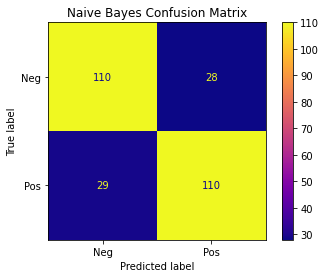

In [9]:
nb_sent_class(df_processed)


## Task 2 - Improved solution

#### Approach and expected improvement

While Naive Bayes (NB) does a commendable job when classifying data (i.e. when ranking a review's class probability), it is not particularly good when used for prediction on unseen data as it tends to be overconfident when estimating a class as a result of its assumption of independance (Russel and Norvig, 2020). Furthermore, NB calculates the class prior probabilities based on the supplied training data, which may not be representative of the real world probabilities (Starmer, 2022). In the case of consumer reviews, research has shown that people are around ten times more likely to post a negative review than a positive one (Thomas, 2018), meaning that because we have supplied negative and positive reviews in equal amounts NB will not be able to accurately predict the prior probability that a given review belongs to a specific class if it were tested on more imbalanced real world data. 

In order to improve on the prediction accuracy of Task 1 I opted to use a linear support vector machine (SVM), while also modifying the vectorising approach to better capture differences between review strings. 

###### Vectoriser changes

The Naive Bayes function in Task 1 used the *CountVectorizer* function to convert each review into a usable matrix of values, each corresponding to the count of a given word, and thus create a 'Bag of Words'. The problem with this approach is that, in the case of sentiment, it might be that words that appear less frequently would be overshadowed by those that are very common, while actually they should have more impact on whether a review could be seen as positive or negative than the more abundant words. 

To counter this I applied a *Term Frequency - Inverse Document Frequency* (Tfidf) function, which takes the counts of word frequency as in *CountVectorizer* and converts them into weights by multiplying their frequency by their relationship with the number of reviews divided by the number of reviews containing the word. This output is then normalised. Using a matrix of weightings like this should allow those terms that are less common but more indicative of a given class to have a greater influence on the resulting prediction accuracy. 

Rather than accepting the default parameters for the *TfidfVectorizer* function, I applied some variations which are likely to improve the predictive capacity when supplied to the SVM agorithm:
- Set the *ngram_range* to (1,2), meaning that the vectoriser would capture both unigrams (as in Naive Bayes) but also bigrams (i.e. ordered words pairs). This would allow the matrix to record relationships between words and hopefully be better able to distinguish when certain combinations of words can be attributed to one class or another;
- Used document frequency parameters of *min_df=3* and *max_df=0.8*. The minimum df setting means that words that appear in less than three reviews are excluded from the matrix counts, while the maximum df setting will conversly ignore words that are present in more than 80% of reveiws. The reasoning behind these settings are that if words are either far too common or extremely rare then they are unlikely to be of any significant use in predicting the class of any unseen reviews, and are thus better left out of the 'Bag of Words'. 
- The setting *sublinear_tf* was set to True, whereby the function will not assign linear weightings to term frequencies that appear at different rates. For example, a term that appears ten times is not ten times as likely to impact the review classifcation than one that appears only twice (Manning *et al.*, 2008). 

###### SVM Algorithm

The SVM algorithm differs from the NB algoritm used in Task 1 in that it is not based on probabilities derived from the training data but rather on their spatial relationships and how they can be divided onto classes by a separating hyperplane (Russel and Norvig, 2020). This means that the relative proportions of postive and negative reviews supplied in the training data will not skew the expected probabilities towards one or another while also not needing to assume independance of data points for each token count or weight. 

Further, this function also handles high dimentionality very well, which is well suited to a very large matrix like that used here. Using a linear SVM, as I have in Task 2, gives the algorithm the ability to apply the training data to high-demensional space where the data is more easily seperated and a hyperplane applied when it would otherwise not be possible in a lower dimension space (Russel and Norvig, 2020). 

#### Implementation

The implementation of the approach described above can be seen in the cell below, where the function *svm_sent_class* has been defined. Here I have applied the default values for the function as these align well with this task. Penalties, tolerances, and weights were all applied during the Tfidf vectorisation phase and therefore did not need to be applied again here. 

The split between training and testing data was done exactly as in Task 1, principally for ease of comparison. Also like Task 1, the output returns the predicted accuracy of the SVM model and a confusion matrix plot to show the number of correct and incorrect predictions.

#### Comparison between task 1 & 2

There are two main areas to compare these two algorithms - processing speed and prediction accuracy. On the first parameter they both run very quickly on this dataset and there is no significant difference between them, although it should be noted that the vectorisation for Task 2 was handling both unigrams and bigrams, giving it a larger processing load than that of Task 1. Given that the NB task ran very quickly there was no obvious need for efficiency gains in speed for Task 2, so only an increase in processing time would have seen a measurable decrease in our improvement estimation between the tasks.

Task 1 returned a prediction accuracy of 79.42% on the testing data, while Task 2 had an accuracy of 83.75%, an increase of a little over 4%. This can be considered a measurable enough improvement between the tasks and therefore the changes to both the vectorisation process and the class classifier algorithm was somewhat successful. 

It is likely that this was partly due to the more accurate matrix that was created by the weighting vectorisation of the Tfidf function. If there were any pairs of words that were more indicative of one class over another then this change would have highlighted those, while the NB function would not. Furthermore, the inverse weighting of less common but more class-specific words likely also allowed for a better classification on the test data. The confusion matrix shows six more reviews for both negative and positive classes were correctly predicted using the Task 2 function over that of Task 1. 

Furthermore, while in this test data the class priors of the NB function were accurate for the given data balance and therefore did not result in a greater improvement in functionality in Task 2, the greater dimensionality of the data may have played a role in the improved scores due to the affinity for high dimension data of the SVM function. 

Ideally the best way to quantify which of these improvements was most responsible for the observed improvement would be to break the function down and note the incremental changes for each of the parameters. Furthermore, a k-fold analysis on a number of different random states would also return a more reliable value for the general predictive abilities of each function presented here.

In [10]:
def svm_sent_class(df_in, test_perc=0.2, rand=99):
    df = df_in.copy()
    
    # create vectoriser using the Tfidf module, creating unigrams and bigrams while ignoring very rare
    # or very common words in each review
    vec = TfidfVectorizer(ngram_range=(1, 2),
                          min_df=3,
                          max_df=0.8,
                          sublinear_tf=True)
    
    x = df['Reviews']
    y = df['Sentiment']
    
    classes = ['Pos', 'Neg']
    
    # split the data into training and testing sets (80:20), stratified on the class to ensure an even
    # spread of the two sentiment types
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, 
                                                        test_size=test_perc, random_state=rand)
    
    # transform the review data and transform it to a numerical array
    x_train = vec.fit_transform(x_train).toarray()
    x_test = vec.transform(x_test).toarray()
    
    # create the linear SVM model and fit the training data
    model = svm.LinearSVC()
    model.fit(x_train, y_train)
    
    # create a prediction on the test data and return the accuracy of the prediction, along with a 
    # confusion matrix plot of the results
    prediction = model.predict(x_test)
    accuracy = metrics.accuracy_score(prediction, y_test)
    print(str('Predicted accuracy for Support Vector Machine is {:04.2f}'.format(accuracy * 100)) + '%')
    print('\n')
    print(classification_report(y_test, prediction,target_names=classes))
    con_mat = confusion_matrix(y_test, prediction)
    figure = ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=model.classes_)
    figure = figure.plot(cmap=plt.cm.plasma)
    figure.ax_.set(title='SVM Confusion Matrix')

Predicted accuracy for Support Vector Machine is 83.75%


              precision    recall  f1-score   support

         Pos       0.83      0.84      0.84       138
         Neg       0.84      0.83      0.84       139

    accuracy                           0.84       277
   macro avg       0.84      0.84      0.84       277
weighted avg       0.84      0.84      0.84       277



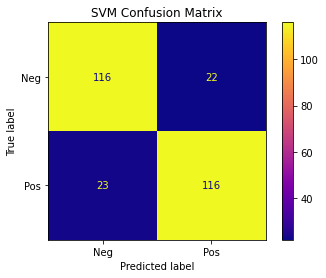

In [11]:
svm_sent_class(df_processed)


### References

- MANNING, C. D., RAGHAVAN P., and SCHUTZE, H., 2008. *Introduction to information retrieval*. Cambridge: Cambridge University Press.
- RUSSELL, S. J., and NORVIG, P., 2020. *Artificial intelligence: a modern approach*. 4th Ed. Boston: Pearson.
- STARMER, J., 2022. *The StatQuest illustrated guide to machine learning*. Great Britain: Amazon.
- THOMAS, A., 2018. *The secret ratio that proves why customer reviews are so important* \[Online\]. Available from: https://www.inc.com/andrew-thomas/the-hidden-ratio-that-could-make-or-break-your-company.html \[Accessed 8th August 2022\].